In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
import pandas as pd
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
import shap
import joblib
from sklearn.preprocessing import StandardScaler

print("📂 Current notebook path:", os.getcwd())

📂 Current notebook path: C:\Users\aleks_k53ffb4


In [30]:
# Load the dataset
df = pd.read_csv("C:/Users/aleks_k53ffb4/OneDrive/Desktop/Coding/Stroke-Prediction-ml/data/raw/stroke.csv")

# Quick overview
display(df.head())
print("\n🧠 Dataset shape:", df.shape)
print("\n📊 Missing values:\n", df.isnull().sum())
print("\n📋 Data types:\n", df.dtypes)
print("\n🔍 Class distribution:\n", df['stroke'].value_counts())

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1



🧠 Dataset shape: (5110, 12)

📊 Missing values:
 id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

📋 Data types:
 id                     int64
gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

🔍 Class distribution:
 stroke
0    4861
1     249
Name: count, dtype: int64


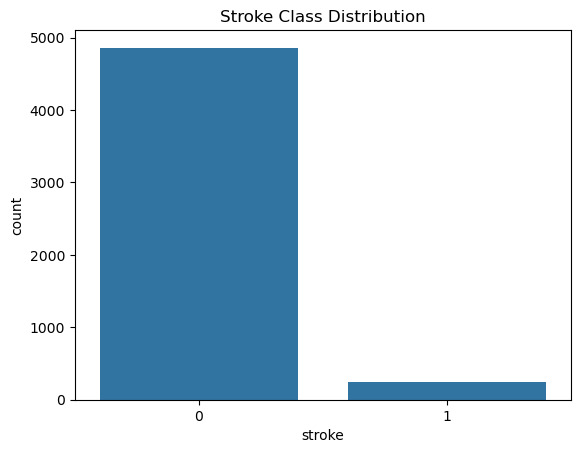

In [31]:
# Visualize class imbalance
sns.countplot(data=df, x='stroke')
plt.title("Stroke Class Distribution")
plt.show()

In [32]:
# Drop ID
if 'id' in df.columns:
    df.drop(columns=['id'], inplace=True, errors='ignore')



# Impute missing BMI with median
df['bmi'] = df['bmi'].fillna(df['bmi'].median())

# Encode binary 'ever_married' and 'Residence_type'
df['ever_married'] = df['ever_married'].map({'Yes': 1, 'No': 0})
df['Residence_type'] = df['Residence_type'].map({'Urban': 1, 'Rural': 0})

# One-hot encode other categoricals
df = pd.get_dummies(df, columns=['gender', 'work_type', 'smoking_status'], drop_first=True)


In [33]:
# Split features & target
X = df.drop(columns=['stroke'])
y = df['stroke']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Scale numeric features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [34]:
# Handle imbalance with SMOTE
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train_scaled, y_train)

print("✅ Preprocessing complete.")
print("X_train shape (after SMOTE):", X_train_bal.shape)
print("y_train distribution:\n", pd.Series(y_train_bal).value_counts())

✅ Preprocessing complete.
X_train shape (after SMOTE): (7778, 16)
y_train distribution:
 stroke
0    3889
1    3889
Name: count, dtype: int64


In [35]:
# Use original feature names after scaling
feature_names = X_train.columns

# Use RFE to rank features
rfc = RandomForestClassifier(n_estimators=100, random_state=42)
rfe = RFE(estimator=rfc, n_features_to_select=10)
rfe.fit(X_train_bal, y_train_bal)

# Show selected features
selected_features = list(feature_names[rfe.support_])
ranking = pd.Series(rfe.ranking_, index=feature_names)

print("✅ Top 10 Selected Features:")
print(selected_features)

print("\n📊 Feature Ranking (1 = selected):")
print(ranking.sort_values())


✅ Top 10 Selected Features:
['age', 'hypertension', 'ever_married', 'Residence_type', 'avg_glucose_level', 'bmi', 'gender_Male', 'work_type_Private', 'work_type_Self-employed', 'smoking_status_never smoked']

📊 Feature Ranking (1 = selected):
age                               1
hypertension                      1
ever_married                      1
Residence_type                    1
avg_glucose_level                 1
bmi                               1
gender_Male                       1
work_type_Private                 1
work_type_Self-employed           1
smoking_status_never smoked       1
heart_disease                     2
smoking_status_formerly smoked    3
smoking_status_smokes             4
work_type_children                5
work_type_Never_worked            6
gender_Other                      7
dtype: int32


In [39]:
# Select only the top features
X_train_sel = X_train_bal[:, rfe.support_]
X_test_sel = X_test_scaled[:, rfe.support_]

# Convert back to DataFrame with selected column names
X_train_sel = pd.DataFrame(X_train_sel, columns=selected_features)
X_test_sel = pd.DataFrame(X_test_sel, columns=selected_features)


models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "SVM": SVC(probability=True, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

for name, model in models.items():
    model.fit(X_train_sel, y_train_bal)
    preds = model.predict(X_test_sel)
    probs = model.predict_proba(X_test_sel)[:, 1]
    
    print(f"\n🔍 Model: {name}")
    print("✅ Classification Report:")
    print(classification_report(y_test, preds))
    print("🎯 ROC-AUC Score:", roc_auc_score(y_test, probs))


🔍 Model: Random Forest
✅ Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.95      0.95       972
           1       0.14      0.16      0.15        50

    accuracy                           0.91      1022
   macro avg       0.55      0.56      0.55      1022
weighted avg       0.92      0.91      0.91      1022

🎯 ROC-AUC Score: 0.756141975308642

🔍 Model: Logistic Regression
✅ Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.75      0.85       972
           1       0.14      0.80      0.24        50

    accuracy                           0.75      1022
   macro avg       0.56      0.77      0.54      1022
weighted avg       0.94      0.75      0.82      1022

🎯 ROC-AUC Score: 0.8427572016460905

🔍 Model: SVM
✅ Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.82      0.89       972
           1       0.13

C:\Users\aleks_k53ffb4\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:25:02] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



🔍 Model: XGBoost
✅ Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       972
           1       0.17      0.14      0.15        50

    accuracy                           0.92      1022
   macro avg       0.56      0.55      0.56      1022
weighted avg       0.92      0.92      0.92      1022

🎯 ROC-AUC Score: 0.7680864197530864


In [37]:
# Create models directory
os.makedirs("models", exist_ok=True)

# Save best model
best_model = LogisticRegression(max_iter=1000, random_state=42)
best_model.fit(X_train_sel, y_train_bal)

joblib.dump(best_model, "models/logistic_regression_stroke.pkl")
print("✅ Model saved to models/logistic_regression_stroke.pkl")

✅ Model saved to models/logistic_regression_stroke.pkl


In [40]:
model = joblib.load("models/logistic_regression_stroke.pkl")

# Make sure selected_features is a list
selected_features = list(selected_features)

X_selected = X_train_sel[selected_features]

# SHAP explainability
explainer = shap.Explainer(model, X_selected)
shap_values = explainer(X_selected)


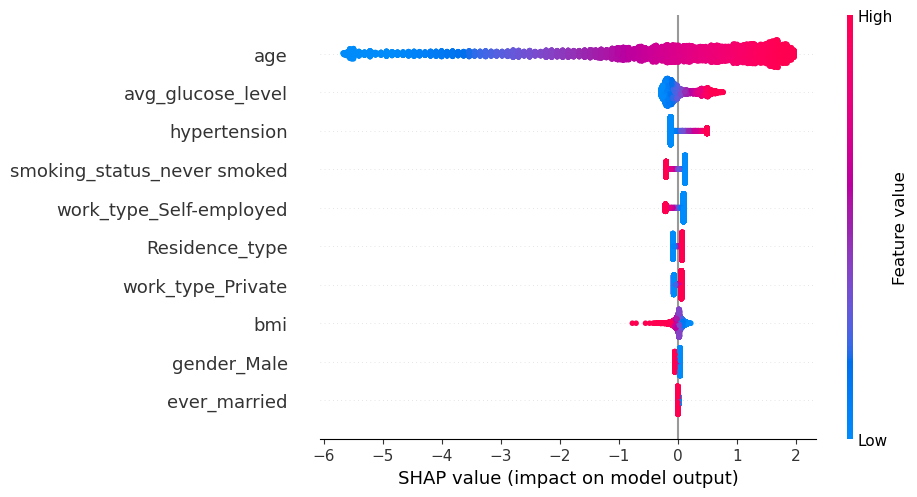

In [41]:
# SHAP Beeswarm Plot
shap.plots.beeswarm(shap_values)

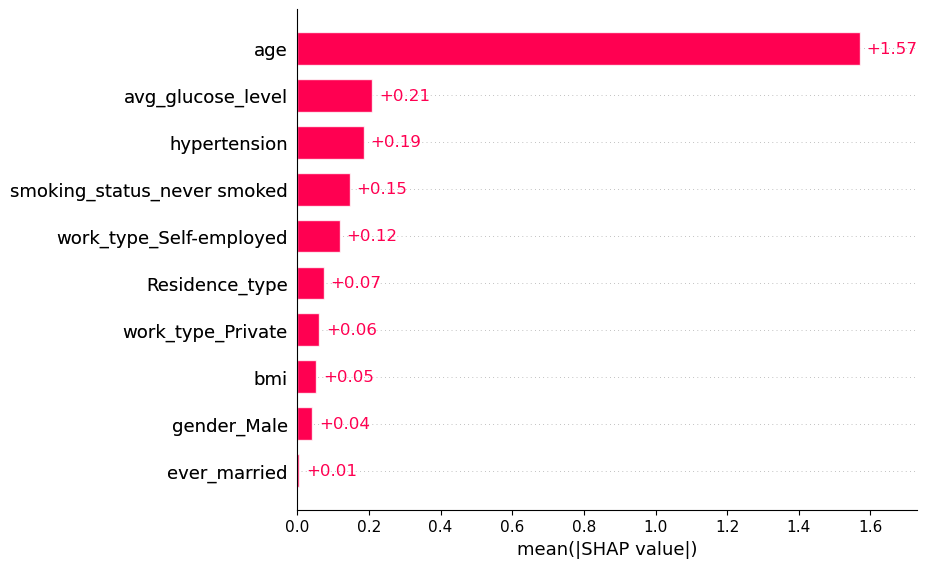

In [42]:
# SHAP Bar Plot
shap.plots.bar(shap_values)